**Goal:**

1. Provide a cheap "black-box" wrapper for an expensive function $f$. When initialized, we define (1) a predictor function $\hat{f}$ that models the expensive function's input-output relationship, (2) a predictive variance function $\sigma^2_\text{pred}(\mathbf{x})$, and (3) a tolerance threshold $\sigma^2_\text{tol}$ for the predictive variance. When queried at a point $\mathbf{x}$, we check whether the predictive variance satisfies the tolerance threshold, $\sigma^2_\text{pred}(\mathbf{x}) \leq \sigma^2_\text{tol}$. If so, we return the cheap prediction. If not, we call the ground-truth function $f(\mathbf{x})$ and update $\hat{f}$.
2. Plug this "black-box" wrapper into an MCMC algorithm instead of $f$
3. Profit!

In [1]:
import numpy as np
import numpy.random as npr
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# step 1!

In [3]:
class GP_Wrapped_Function():
    def __init__(self,
                 f_callable,
                 x_in_bounds,
                 predictive_var_tolerance=0.1,
                 initial_observations=[],
                 kernel=GPy.kern.RBF(1,1.0,1.0)):
        
        '''
        f_callable is the black-box function we're wrapping.
        
        x_in_bounds is a function that accepts an input x and returns true if it's within the expected bounds
        
        predictive_var_tolerance is the maximum predictive variance we are
        willing to tolerate without calling f_callable.
        
        initial_observations is a list of (x,y) pairs
        '''
        
        self.f_groundtruth = f_callable
        self.predictive_var_tolerance_ = predictive_var_tolerance
        self.observations_ = initial_observations
        self.x_in_bounds = x_in_bounds
        self.fit_count_ = 0 # number of times the model has been fit
        self.kernel_ = kernel
        if len(initial_observations) > 0:
            self.fit_model() # assigns to self.model_
        
    def fit_model(self):
        assert(len(self.observations_) < 1000)
        
        self.fit_count_ += 1
        X = np.array([pair[0] for pair in self.observations_])
        y = np.array([pair[1] for pair in self.observations_])
        
        assert(sum([self.x_in_bounds(x) for x in X]) == len(X))
        
        if len(X[0].shape) != 2:
            X = X.reshape((len(X),1))
        if len(y[0].shape) != 2:
            y = y.reshape((len(y),1)) # GPy expects y to be 2 dimensional, i.e. to have shape (N,1) rather than (N,)
        
        # replace with sparse GP?
        self.model_ = GPy.models.GPRegression(X,y,kernel=self.kernel_)
        self.model_.constrain_positive('') # variances can somehow become negative unless constrained
        self.model_.optimize()
    
    def update_model(self,new_observations):
        # currently re-training from scratch
        # to-do: efficient incremental updates
        
        self.observations_ = self.observations_ + new_observations
        self.fit_model()
    
    def __call__(self,X):
        ''' X can either be an N-by-d array of points to be evaluated at or a single d-dimensional
        vector or a scalar'''
        
        # flag for whether to treat X as a single observation or not
        single_input = False
        
        # GPy expects X.ndim==2
        if type(X) != np.ndarray: # if it's an int or float
            X = np.array(X).reshape((1,1))
            single_input = True
        if len(X.shape) != 2: # if it's a vector
            X = X.reshape(len(X),1)
            single_input = True
        
        # check if the single input is in bounds. If not, return -np.inf
        if single_input:
            if not self.x_in_bounds(X):
                return -np.inf
        
        # if this is the first time we're seeing data, feed it to the model and return ground-truth
        if self.fit_count_ == 0:
            y = self.f_groundtruth(X)
            if single_input:
                self.update_model([(X[0],y[0])])
            else:
                self.update_model(zip(X,y))
            if X.shape==(1,1):
                return y[0]
            else:
                return y
        
        # evaluate the model at all queried points, storing prediction and predictive variance
        y_pred,y_pred_var = self.model_.predict(X)
        y_return = np.array(y_pred)
        
        
        # should we return the mean prediction, or should we sample from the conditional distribution?
        # here just returning the mean prediction, but this could easily be altered to return samples
        
        if single_input:
            if np.abs(y_pred_var[0][0]) > self.predictive_var_tolerance_:
                y = self.f_groundtruth(X)
                self.update_model([(X,y)])
                y_return[0] = y
                
            if X.shape==(1,1):
                return y_return[0][0]
            else:
                return y_return[0]
            
        else:
            out_of_bounds = np.array([self.x_in_bounds(x) for x in X])
            in_bounds = 1-out_of_bounds
            
            y_return[out_of_bounds] = -np.inf
            
            # bit-vector of which queries yielded an intolerable predictive variance and are in_bounds
            unpredictables = (np.abs(y_pred_var) > self.predictive_var_tolerance_) * in_bounds

            # if there are any queries for which we'll need to consult the groundtruth function, do so
            # and update the model accordingly
            if sum(unpredictables) > 0:
                batch_update_x = X[unpredictables]
                batch_update_y = np.array([self.f_groundtruth(x) for x in batch_update_x])
                self.update_model(zip(batch_update_x,batch_update_y))
                y_return[unpredictables] = batch_update_y
            return y_return

In [4]:
class Black_Box():
    def __init__(self,function):
        self.call_count_ = 0
        self.function_ = function
    
    def __call__(self,x):
        self.call_count_ += 1
        return self.function_(x)

def bounded_fxn(x,bounds=10):
    if np.abs(x) > bounds:
        return -np.inf
    return np.nan_to_num((np.sin(x**2) / (x**2+1)) - (0.1*x**2))

bounds = 5
test_fxn = Black_Box(lambda x:bounded_fxn(x,bounds))

npr.seed(0)
train_range = 5
X_train = npr.rand(100,1)*train_range - (train_range / 2.0)
y_train = np.array([test_fxn(x) for x in X_train]).reshape((len(X_train),1))

test_range = train_range*2.0
X_test = npr.rand(1000,1)*test_range - (test_range / 2.0)
y_test = np.array([test_fxn(x) for x in X_test]).reshape((len(X_test),1))

In [7]:
# fit a GP to the training set and make predictions on the test set
regressor = GPy.models.GPRegression(X_train,y_train,kernel=GPy.kern.RBF(1,1.0,1.0))
regressor.optimize()
y_pred,y_pred_var = regressor.predict(X_test)

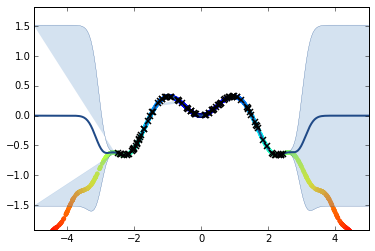

In [8]:
# hmm looks like the GPy plotting function is broken...
regressor.plot([X_test.min(),X_test.max()])
plt.scatter(X_test,y_test,c=np.abs(X_test),linewidths=0)

In [9]:
# quick and dirty replacement plotter
def plot_GP(GP,xlim=[]):
    if len(xlim) != 2:
        xlim = [float(np.min(regressor.X)),float(np.max(regressor.X))]
    x = np.linspace(xlim[0],xlim[1],10000)
    y_pred,y_var = GP.predict(x.reshape((len(x),1)))
    y_pred = y_pred[:,0]
    y_var = y_var[:,0]
    y_var = 1.96 * np.sqrt(np.abs(y_var))
    plt.plot(x,y_pred,c='black',linewidth=2)
    plt.fill_between(x,y_pred - y_var, y_pred + y_var,color='grey',interpolate=True,antialiased=True,alpha=0.3)
    plt.scatter(GP.X,GP.Y,linewidths=0)

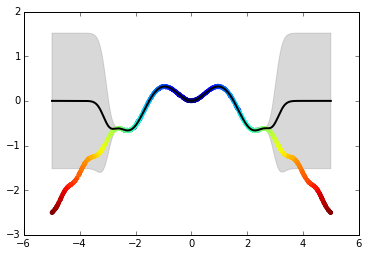

In [10]:
plot_GP(regressor,xlim =[X_test.min(),X_test.max()])
plt.scatter(X_test,y_test,c=np.abs(X_test),linewidths=0)

Color represents x-coordinate of each test point


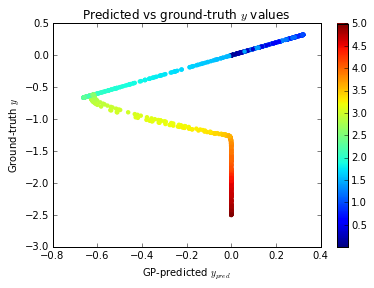

In [11]:
# plot predicted vs ground-truth y values
plt.scatter(y_pred,y_test,c=np.abs(X_test),linewidths=0)
plt.xlabel(r'GP-predicted $y_{pred}$')
plt.ylabel(r'Ground-truth $y$')
plt.title(r'Predicted vs ground-truth $y$ values')
plt.colorbar()
print('Color represents x-coordinate of each test point')
# the blue diagonal is a low-error regime in which the GP is being tested in the range it was trained
# the green-ish dots represent predictions made slightly outside the range of training points
# the vertical line is a high-error regime in which the GP is being tested far outside the range in which
# it was trained and simply predicts the mean function 0

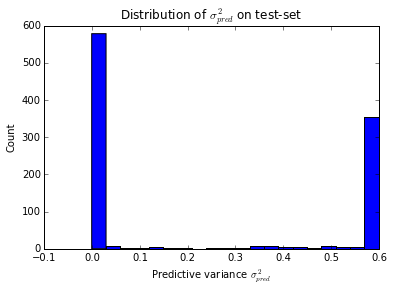

In [12]:
plt.hist(y_pred_var,bins=20);
plt.xlabel(r'Predictive variance $\sigma^2_{{pred}}$')
plt.ylabel('Count')
plt.title(r'Distribution of $\sigma^2_{{pred}}$ on test-set')

In [13]:
# step 2!

In [14]:
import emcee

In [15]:
npr.seed(0)

test_fxn.call_count_ = 0

sampler = emcee.EnsembleSampler(10, 1, test_fxn)
sampler.run_mcmc(npr.rand(10,1),5000)

print(test_fxn.call_count_)

50010


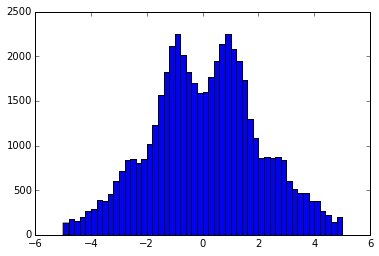

In [16]:
# ground-truth distribution
ground_truth = np.histogram(sampler.flatchain,bins=50,range=(-5,5),normed=True)[0]
plt.hist(sampler.flatchain,bins=50);

In [17]:
init_observations = zip(X_train[:50],y_train[:50])
test_fxn.call_count_ = len(init_observations)

wrapped_black_box = GP_Wrapped_Function(test_fxn,
                                        x_in_bounds=lambda x:np.sum(np.abs(x))<=5,
                                        initial_observations=init_observations,
                                        predictive_var_tolerance=0.01)

In [18]:
len(wrapped_black_box.observations_)

50

In [19]:
npr.seed(0)
sampler = emcee.EnsembleSampler(10, 1, wrapped_black_box)
sampler.run_mcmc(npr.rand(10,1)-0.5,5000)
print(test_fxn.call_count_,len(wrapped_black_box.observations_),wrapped_black_box.fit_count_)

(144, 144, 95)


In [20]:
approximate = np.histogram(sampler.flatchain,bins=50,range=(-5,5),normed=True)[0]

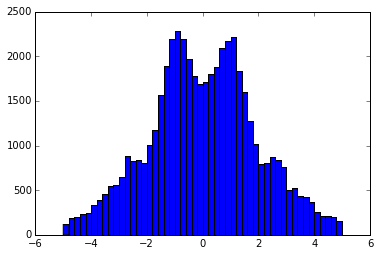

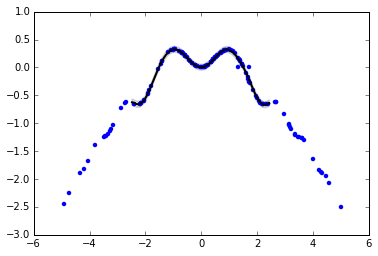

In [21]:
# GP-accelerator-sampled distribution using ~50,000 "virtual samples"
# Accuracy: looks about right-- could compute cross-entropy or something to quantify difference
# Savings: made only 144 total calls to the test_fxn, rather than 50,000!
# Cost: required 95 rounds of GP-model-fitting.
plt.hist(sampler.flatchain,bins=50);
plt.figure()
plot_GP(wrapped_black_box.model_)

In [23]:
# so, this looks quite close to ground truth
from scipy.stats import entropy
entropy(approximate,ground_truth)

0.0032893827663663701

In [34]:
# let's do this again under slightly different conditions and see if it breaks
init_observations = zip(X_train[:50],y_train[:50])
test_fxn.call_count_ = len(init_observations)

wrapped_black_box = GP_Wrapped_Function(test_fxn,
                                        x_in_bounds=lambda x:np.sum(np.abs(x))<=5,
                                        initial_observations=init_observations, 
                                        predictive_var_tolerance=0.02) # slightly increase tolerance

npr.seed(0)
sampler = emcee.EnsembleSampler(10, 1, wrapped_black_box)
sampler.run_mcmc(npr.rand(10,1)-0.5,5000)
print(test_fxn.call_count_,len(wrapped_black_box.observations_),wrapped_black_box.fit_count_)

(51, 51, 2)


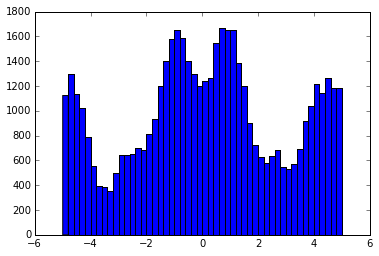

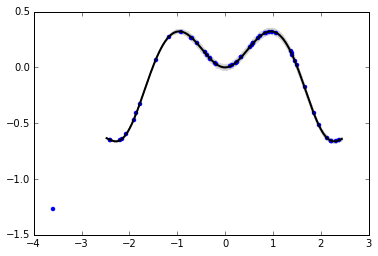

In [35]:
# hmm that doesn't look good: note overly high density predictions in |x|>3
# also note that only 1 further update to the model was made after initial samples, i.e.
# the predictive_var_tolerance threshold was only reached once

plt.hist(sampler.flatchain,bins=50);
plt.figure()
plot_GP(wrapped_black_box.model_)

In [36]:
# this is ~100x worse than the previous example where we set predictive_var_tolerance=0.01
approximate_2 = np.histogram(sampler.flatchain,bins=50,range=(-5,5),normed=True)[0]
entropy(approximate_2,ground_truth)

0.25327255901314638

In [37]:
# so yay it kind of works sometimes in some cases

# But based on some tinkering it looks like there are a few problems:
# 1. sometimes not sampling the correct distribution! Hack: impose bounds. Possible diagnosis:
# Since the GP's mean function is zero and the target function in this case has values below zero
# in some regions, it will make nonsensical predictions with poorly calibrated error estimates when extrapolating
# in those regions
# 2. why aren't we getting accurate error estimates outside of the interval [-2.5,2.5]?
# 3. Sensitive dependence on number of initial samples: must be greater than ~50.
# 4. Sensitive dependence on predictive_var_tolerance
# 5. Unsure whether GPy is adjusting the kernel scale during fitting-- if so, this makes an absolute
# variance threshold meaningless